In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import neurokit2 as nk

## Lendo arquivo com 219 exames

In [ ]:
with open("data/data_219.pkl", 'rb') as fin:
    res = pickle.load(fin)
res.keys()

In [3]:
with open("data/temp.pkl", 'rb') as fin:
    temp = pickle.load(fin)
temp.shape

(1585, 7680, 1)

In [20]:
type(res['data'])

numpy.ndarray

In [ ]:
# 1843200 em 128hz -> 4hrs
res['data'].shape

(219, 1843200)

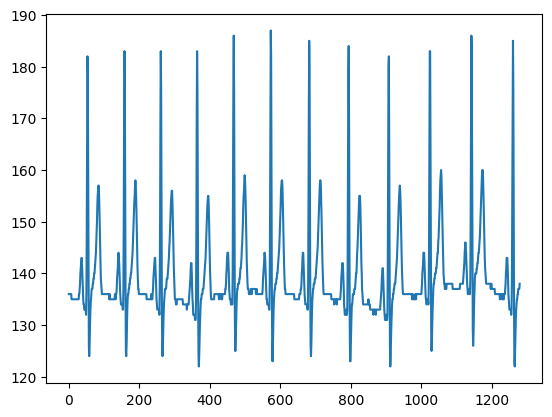

In [19]:
exemplo = res['data'][0]
plt.plot(exemplo[:128*10])

## TXT -> PKL

In [ ]:
base_path = '/home/kelvin/Downloads/base_chagas'
df = pd.read_excel('data/chagas_idades.xlsx')
df["death_label"] = ((df['Time'] < 5) & (df['Obito_MS'] == 1)).astype(np.int32)
df.head(1)

,ID,Name,Date Nasc,Data Holter,Age,Time,Sex,Event (FU-5 years),AVC,Obito,Obito_MS,death_label
0,1,Adão Severo de Souza,1950-11-29,2013-05-22,62,5.0,1,0,0,0,0,0


In [ ]:
data_list = []
death_list = []
peaks_list = []
actual_fs, desired_fs = 480, 128
for idx, row in df.iterrows():
    id_value = row['ID']
    if id_value % 25 == 0:
        print(f"Processing exam {id_value}...")
    death_value = row['death_label']

    txt_filename = os.path.join(base_path, f"sinal{id_value:03d}.txt")

    signal = np.loadtxt(txt_filename, dtype=np.float32)
    resampled = nk.signal_resample(
        signal, sampling_rate=actual_fs, desired_sampling_rate=desired_fs, method='interpolation'
    )
    del signal

    temp, _ = nk.ecg_peaks(resampled, sampling_rate=desired_fs, method='neurokit')

    data_list.append(resampled)
    death_list.append(death_value)
    peaks_list.append(temp['ECG_R_Peaks'].values.astype(np.int32))

final_data = {
    "data": np.array(data_list, dtype=object),
    "death_label": np.array(death_list, dtype=np.int32),
    "rpeaks": np.array(peaks_list, dtype=object)
}

with open(f'data_{desired_fs}hz.pkl', 'wb') as pkl_file:
    pickle.dump(final_data, pkl_file)

Processing exam 25...
Processing exam 50...
Processing exam 75...
Processing exam 100...
Processing exam 125...
Processing exam 150...
Processing exam 175...


## Leitura do PKL gerado

In [2]:
with open("data/data_128hz.pkl", 'rb') as fin:
    res = pickle.load(fin)
res.keys()

dict_keys(['data', 'death_label', 'rpeaks'])

In [7]:
type(res['data']), res['data'].shape

(numpy.ndarray, (176,))

In [8]:
data = res['data']
max_len = 0
min_len = float('inf')

for sig in data:
    max_len = max(max_len, len(sig))
    min_len = min(min_len, len(sig))

print(f"Max len: {max_len}")
print(f"Max len in hrs: {max_len / 128 / 60 / 60:.2f}")
print(f"Min len: {min_len}")
print(f"Min len in hrs: {min_len / 128 / 60 / 60:.2f}")

Max len: 10920961
Max len in hrs: 23.70
Min len: 211969
Min len in hrs: 0.46


## Leitura dos arquivos pre-processados

In [24]:
names = [
    "x_train", "y_train", "pid_train", 
    "x_val", "y_val", "pid_val", 
    "x_test", "y_test", "pid_test"
]
for name in names:
    with open(f"data/preprocessed/{name}.pkl", "rb") as f:
        data = pickle.load(f)
        print(f"{name}: {data.shape}")

x_train: (155768, 7680, 1)
y_train: (155768, 2)
pid_train: (155768,)
x_val: (23728, 7680, 1)
y_val: (23728, 2)
pid_val: (23728,)
x_test: (26086, 7680, 1)
y_test: (26086, 2)
pid_test: (26086,)
